# Interacting with CLIP (Zero-shot segmentation)

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/ricardodeazambuja/CLIP.git

In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.13.1+cu117


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

Model stats for ViT-B/32
- vision_width: 768
- vision_layers: 12
- vision_patch_size: 32
- grid_size: 7
- image_resolution: 224
- context_length: 77
- vocab_size: 49408
- transformer_width: 512
- transformer_heads: 8
- transformer_layers: 12
- total number of parameters: 151,277,313


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7ff9286b0b80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
from PIL import Image
from PIL.Image import FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import interpolate

from torchvision.transforms.functional import to_tensor, normalize, gaussian_blur

Original size (912, 913)
Final size (800, 800)


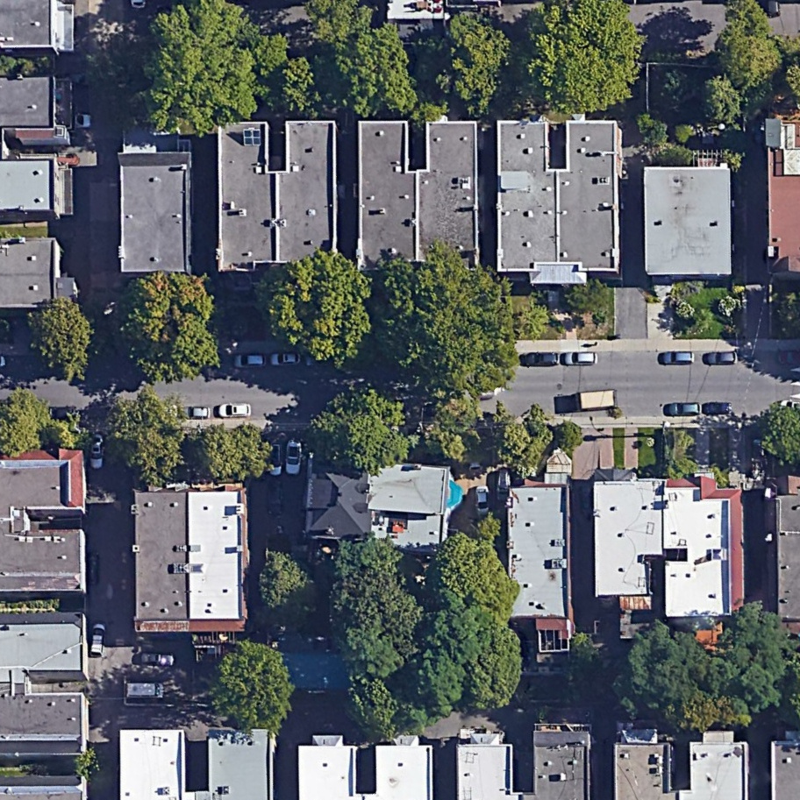

In [7]:
# input_image = Image.open('test_google_earth.png')
# input_image = Image.open('../example_earth_100m.jpg')
input_image = Image.open('../example_earth_200m.jpg')
# input_image = Image.open('../example_earth_high_altitude.jpg')


#
# The input image needs to be square
# 
print(f"Original size {input_image.size}")
input_image = input_image.resize((800,800))
print(f"Final size {input_image.size}")
input_image

In [9]:
prompt = "a photo of a neighbourhood"
text_tokens = clip.tokenize([prompt]).cuda()
image_input = preprocess(input_image.copy()).unsqueeze(0).cuda()

with torch.no_grad():
    image_features, image_attn_weights = model.encode_image(image_input)
    image_features = image_features.float()
    text_features, text_attn_weights = model.encode_text(text_tokens)
    text_features = text_features.float()
        
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features @ image_features.T

print(similarity)

tensor([[0.3048]], device='cuda:0')


## Simplest way: adapting from this post
https://www.pinecone.io/learn/zero-shot-object-detection-clip/

In [10]:
def mirror_padding(input_image, grid_size, window):

    patch_dim = int(input_image.size[0]/grid_size)
    assert (input_image.size[0] % grid_size) == 0, f"grid_size {grid_size} must match image size {input_image.size}!"
    padding = (window*patch_dim)//2

    # crop: left, upper, right, and lower
    crop_top = input_image.crop((0,
                                 0,
                                 input_image.size[0],
                                 padding))

    crop_bottom = input_image.crop((0,
                                    input_image.size[0]-padding,
                                    input_image.size[0],
                                    input_image.size[0]))

    crop_left = input_image.crop((0,
                                  0,
                                  padding,
                                  input_image.size[0]))

    crop_right = input_image.crop((input_image.size[0]-padding,
                                   0,
                                   input_image.size[0],
                                   input_image.size[0]))

    crop_top_left = input_image.crop((0,
                                      0,
                                      padding,
                                      padding))

    crop_top_right = input_image.crop((input_image.size[0]-padding,
                                       0,
                                       input_image.size[0],
                                       padding))

    crop_bottom_left = input_image.crop((0,
                                         input_image.size[0]-padding,
                                         padding,
                                         input_image.size[0]))

    crop_bottom_right = input_image.crop((input_image.size[0]-padding,
                                          input_image.size[0]-padding,
                                          input_image.size[0],
                                          input_image.size[0]))

    padded_img = Image.new(input_image.mode, (input_image.size[0]+2*padding, input_image.size[0]+2*padding), (0,0,0))
    padded_img.paste(crop_top.transpose(FLIP_TOP_BOTTOM), (padding,0))
    padded_img.paste(crop_bottom.transpose(FLIP_TOP_BOTTOM), (padding,input_image.size[0]+padding))
    padded_img.paste(crop_left.transpose(FLIP_LEFT_RIGHT), (0,padding))
    padded_img.paste(crop_right.transpose(FLIP_LEFT_RIGHT), (input_image.size[0]+padding,padding))

    padded_img.paste(crop_top_left.transpose(FLIP_LEFT_RIGHT).transpose(FLIP_TOP_BOTTOM), (0,0))
    padded_img.paste(crop_top_right.transpose(FLIP_LEFT_RIGHT).transpose(FLIP_TOP_BOTTOM), (input_image.size[0]+padding,0))

    padded_img.paste(crop_bottom_left.transpose(FLIP_LEFT_RIGHT).transpose(FLIP_TOP_BOTTOM), (0,input_image.size[0]+padding))
    padded_img.paste(crop_bottom_right.transpose(FLIP_LEFT_RIGHT).transpose(FLIP_TOP_BOTTOM), (input_image.size[0]+padding,input_image.size[0]+padding))

    padded_img.paste(input_image, (padding, padding))


    image_input = to_tensor(padded_img)
    
    return image_input, patch_dim, padding

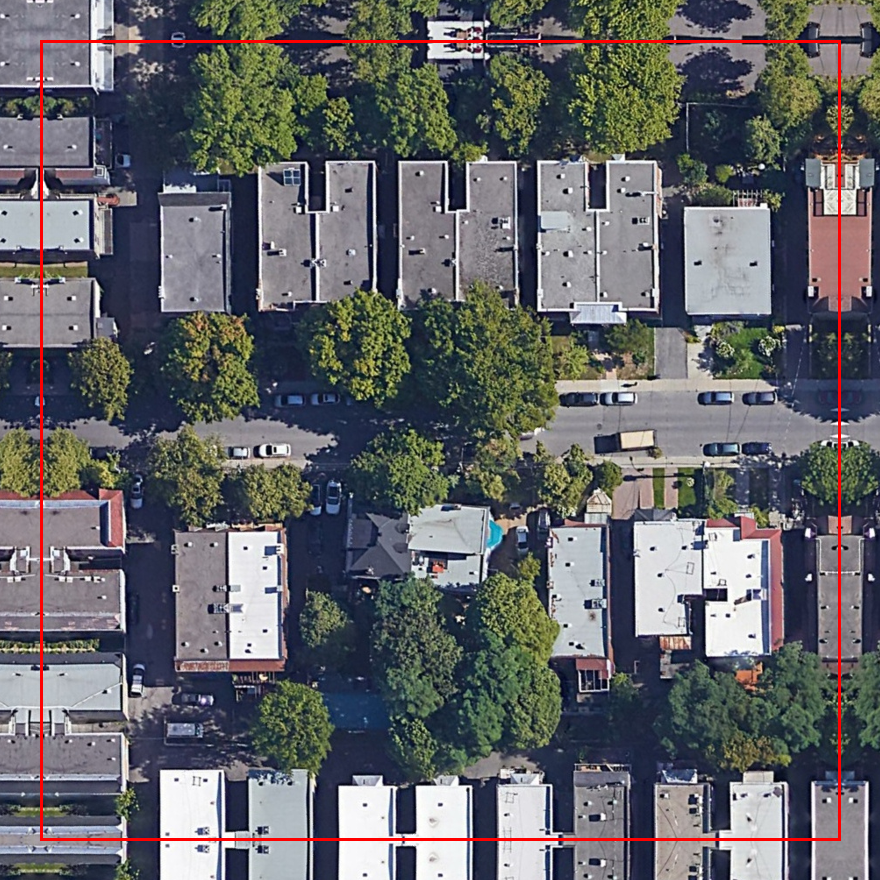

In [11]:
grid_size = 50
window = 5
image_input, patch_dim, padding = mirror_padding(input_image, grid_size, window)

from PIL import ImageDraw
img = Image.fromarray((image_input.permute(1,2,0).numpy()*255).astype('uint8')).copy()
draw = ImageDraw.Draw(img)
draw.rectangle([(padding, padding), (img.size[0]-padding, img.size[1]-padding)], 
               fill=None, outline=(255,0,0), width=3)
img

In [12]:
def generate_similarity_tensor(image_input, model, 
                               grid_size, window, patch_dim, 
                               prompt="a photo of a building"):
    text_tokens = clip.tokenize([prompt]).cuda()
    
    input_resolution = model.visual.input_resolution

    batches = torch.zeros((grid_size,3,input_resolution,input_resolution)).float().cuda()
    similarities = torch.zeros((grid_size,grid_size)).float().cuda()
    for Y in range(0,grid_size, 1): # this should be done as a batch...
        for X in range(0,grid_size, 1): # this should be done as a batch...
            patch_input = image_input[:, 
                                      Y*patch_dim:Y*patch_dim+window*patch_dim, 
                                      X*patch_dim:X*patch_dim+window*patch_dim
                                     ].unsqueeze(0)
            patch_input = interpolate(patch_input, (input_resolution,input_resolution), 
                                      mode='bilinear', align_corners=True)
            patch_input = normalize(patch_input,
                                    mean=(0.48145466, 0.4578275, 0.40821073), 
                                    std=(0.26862954, 0.26130258, 0.27577711))
            batches[X] = patch_input.cuda()

        with torch.no_grad():
            image_features, image_attn_weights = model.encode_image(batches)
            image_features = image_features.float()
            if Y==0:
                text_features, text_attn_weights = model.encode_text(text_tokens)
                text_features = text_features.float()

        image_features /= image_features.norm(dim=1, keepdim=True)
        text_features /= text_features.norm(dim=1, keepdim=True)
        similarity = (text_features @ image_features.T)

        similarities[Y, :] += similarity[0]
    
    return similarities

In [13]:
grid_size = 50
window_sizes = [10,20]

prompt = "a photo of a tree"
similarities = torch.zeros((grid_size, grid_size)).float().cuda()
for wi, window in enumerate(window_sizes):
    image_input, patch_dim, _ = mirror_padding(input_image, grid_size, window)
    similarities += generate_similarity_tensor(image_input, model, 
                                               grid_size, window, patch_dim, 
                                               prompt)

In [14]:
blur_kernel = 9,9
heat_map = gaussian_blur(similarities.unsqueeze(0), blur_kernel).squeeze().cpu().numpy()

# This normalization will ALWAYS highlight the max values. 
# In a situation where there's nothing, it will probably show noise.
# heat_map -= heat_map.mean()
# heat_map = np.clip(heat_map, 0, np.inf)
# heat_map -= heat_map.min()
# heat_map /= heat_map.max()

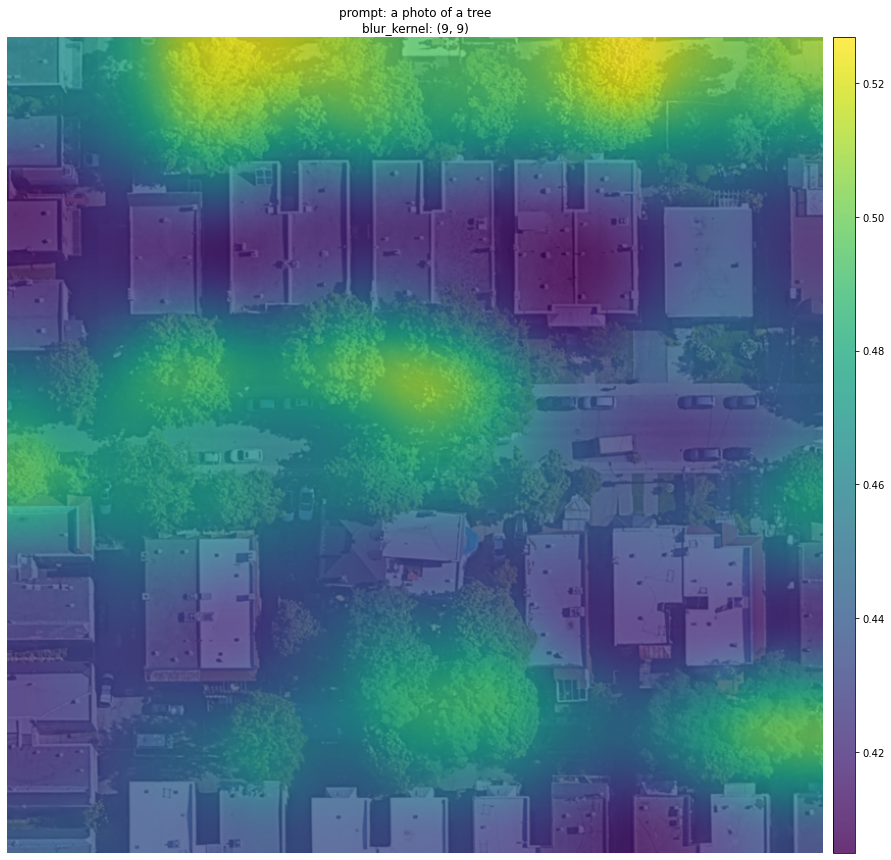

In [15]:
fig=plt.figure(figsize=(15,15))
plt.imshow(np.asarray(input_image))
im = plt.imshow(np.asarray(Image.fromarray(heat_map).resize(input_image.size)), alpha=0.8)
# plt.imshow(heat_map, alpha=0.8)
plt.axis("off")
plt.title(f"prompt: {prompt}\nblur_kernel: {blur_kernel}")
ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
plt.show()